**Train the model on GPU in Google Colab and save the state dictionary to Google Drive**




**Source: Torchvision Finetuning instance segmentation model Tutorial:**

https://colab.research.google.com/github/pytorch/vision/blob/temp-tutorial/tutorials/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=at-h4OWK0aoc


In [1]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

UsageError: Cell magic `%%shell` not found.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

# Google drive needs to have a folder 'temp/towplanetracking/training/'
# use "copy_to_google_drive.sh" to copy everything necessary for training.


Mounted at /content/gdrive


In [3]:
%%shell

cd /content/gdrive/MyDrive/temp/towplanetracking/training/
ls

data  pytorch_utils  saved_state  train_model_v1.1.ipynb  train_model_v1.ipynb


In [4]:
from PIL import Image
import os

In [5]:
project_dir = "/content/gdrive/MyDrive/temp/towplanetracking/training/"

In [6]:
# change current working directory of python 
import sys
import os

os.chdir('/content/gdrive/MyDrive/temp/towplanetracking/training/') 
print("new working directory: ", os.getcwd())

#dir_images = "data/images_original"
#dir_masks = "data/masks_original"
dir_images = "data/images_resized_400px"
dir_masks = "data/masks_resized_400px"


new working directory:  /content/gdrive/MyDrive/temp/towplanetracking/training


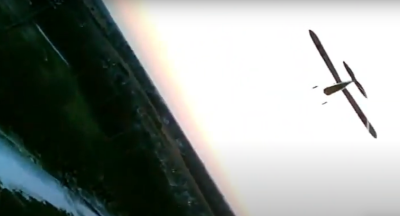

In [7]:
Image.open('data/images_resized_400px/img_0.png')

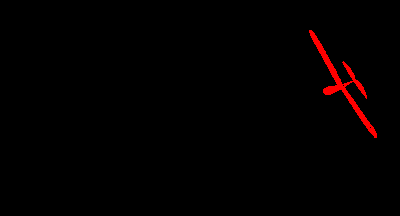

In [8]:
import numpy as np
#mask = Image.open('data/masks_original/mask_0.png')
mask = Image.open('data/masks_resized_400px/mask_0.png')
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0 # index 1 is red
])

mask

In [9]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class TowplaneDataset(torch.utils.data.Dataset):
    def __init__(self, dir_images, dir_masks, transforms=None):
        self.dir_images = dir_images
        self.dir_masks = dir_masks
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(dir_images)))
        self.masks = list(sorted(os.listdir(dir_masks)))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.dir_images, self.imgs[idx])
        mask_path = os.path.join(self.dir_masks, self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)  

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set of binary masks
        masks = (mask == obj_ids[:, None, None])

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        #im_path, mask_path = __getdebuginfo__(idx)
        #print(" {} ; {}".format(im_path, mask_path))
        
        return img, target

    def __len__(self):
        return len(self.imgs)

    def __getdebuginfo__(self, idx):
      img_path = os.path.join(self.root, foldername_images, self.imgs[idx])
      mask_path = os.path.join(self.root, foldername_masks, self.masks[idx])
      return img_path, mask_path



In [10]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [11]:
from pytorch_utils.engine import train_one_epoch, evaluate
import pytorch_utils.utils as utils
import pytorch_utils.transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [12]:
# create datasets and dataloader
torch.manual_seed(1)
N_test_images = 50

# use our dataset and defined transformations
dataset = TowplaneDataset(dir_images, dir_masks, get_transform(train=True))
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-N_test_images])

dataset_test = TowplaneDataset(dir_images, dir_masks, get_transform(train=False))
dataset_test = torch.utils.data.Subset(dataset_test, indices[-N_test_images:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [14]:
# let's train
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every print_freq iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [  0/219]  eta: 0:08:13  lr: 0.000028  loss: 5.4425 (5.4425)  loss_classifier: 0.4968 (0.4968)  loss_box_reg: 0.1701 (0.1701)  loss_mask: 4.7681 (4.7681)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0074 (0.0074)  time: 2.2534  data: 1.6294  max mem: 1376
Epoch: [0]  [  1/219]  eta: 0:04:24  lr: 0.000051  loss: 5.4425 (5.8148)  loss_classifier: 0.4968 (0.5038)  loss_box_reg: 0.0515 (0.1108)  loss_mask: 4.7681 (5.1679)  loss_objectness: 0.0000 (0.0097)  loss_rpn_box_reg: 0.0074 (0.0227)  time: 1.2146  data: 0.8154  max mem: 1376
Epoch: [0]  [  2/219]  eta: 0:12:25  lr: 0.000074  loss: 6.0763 (5.9020)  loss_classifier: 0.5107 (0.5316)  loss_box_reg: 0.0651 (0.0956)  loss_mask: 5.4063 (5.2473)  loss_objectness: 0.0099 (0.0097)  loss_rpn_box_reg: 0.0078 (0.0177)  time: 3.4359  data: 3.0991  max mem: 1649
Epoch: [0]  [  3/219]  eta: 0:09:27  lr: 0.000097  loss: 5.4425 (5.7482)  loss_classifier: 0.4968 (0.5104)  loss_box_reg: 0.0651 (0.1240)  loss_mask: 4.7681 (5.0921) 

In [15]:
import os
# save model's state dictionary to google drive
utils.mkdir("saved_state")
torch.save(model.state_dict(), 'saved_state/model_state_dict.pt')
torch.save(optimizer.state_dict(), 'saved_state/optimizer_state_dict.pt')

In [16]:
# pick one image from the test set
img, _ = dataset_test[19]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

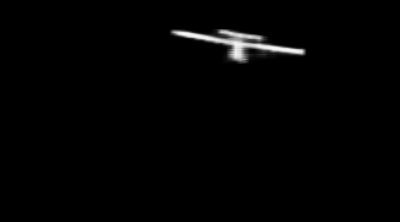

In [17]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

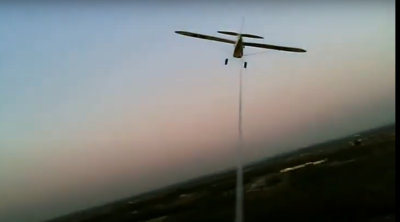

In [18]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())